
# Project 1: Digit Classification with KNN


# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [4]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [5]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [6]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

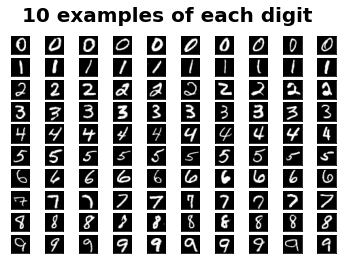

In [7]:
def Q1(num_examples=10):
    ### STUDENT START ###
    # Create sub-plots 10x10
    fig, ax = plt.subplots(10, 10, sharey=True)
    
    # initialize a dictionary that keeps a count of each label
    # as we need to draw only 10 labels of each kind
    count = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, 'total':0}
    
    # we iterate through the training data
    for i in range(len(mini_train_data)):
        
        # if the grand total count is 100 then quit
        if count.get('total') == 100:
            break
            
        # current label
        k = mini_train_labels[i]
        
        # if the current label count is 10
        # then continue to next item
        if count.get(k)==10:
            continue
            
        # create a tile 28x28
        img = mini_train_data[i].reshape(28, 28)
        
        # add tile to the axis and show
        # update the count
        ax[int(k),count.get(k)].imshow(img, cmap='gray')
        count[str(k)] += 1
        count['total'] += 1
        
    # finally but not the least, remove the x and y ticks
    # set the super title
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.suptitle('10 examples of each digit', fontweight ="bold", fontsize=20)
    
  ### STUDENT END ###

Q1(10)

### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model. 
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label. 
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

<span style="font-family:Verdana; color: green;"> In the cell below, we have implemented the function Q2() to iterate through the provided k_values. For each k value, we instantiate a KNeighborsClassifier model with n_neightbors set to k, train the model on the mini train set, evaluated the model with dev set, and finally we print the accuracy using the 'score' function. For k == 1, we also printed the classification report with the help of classification_report module provided under the sklearn.metrics package. </span>

In [8]:
def Q2(k_values):
    ### STUDENT START ###
    
    # iterate over k_values
    for k in k_values:
        
        # instantiate the KNN model
        model = KNeighborsClassifier(n_neighbors=k)
        
        # fit the mini train set
        model.fit(mini_train_data, mini_train_labels)
        
        # evaluate the model for dev set
        pred = model.predict(dev_data)
        
        # calculate & print the accuracy for this model
        acc = sum(pred == dev_labels)/len(dev_labels)
        print("k: "+str(k) + " acc: ", model.score(dev_data, dev_labels))
        # if the k is 1 print the classification report
        if k == 1:
            print(classification_report(dev_labels, pred))
    ### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
Q2(k_values)

k: 1 acc:  0.884
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

k: 3 acc:  0.876
k: 5 acc:  0.882
k: 7 acc:  0.877
k: 9 acc:  0.875


Answer to part 4: 

<span style="font-family:Verdana; color: green;"> Recall measures the ratio of number of labels correctly identified with the total of number of those labels. Going by this definition recall percentage for label "8" is the lowest at 77%. So the KNeighborsClassifier finds label "8" the most difficult to identify. </span>

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to: 
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

<span style="font-family:Verdana; color: green;"> In the cell below, we have implemented function Q3(). This function takes 4 arguments: (1) train_sizes, (2) accuracies, (3), train_times, and (4) eval_times. As the name suggests, train_sizes is list of sizes (data size) we want to experiment. The next 3 arguments are list containers where Q3 will append as it runs the experiment. Q3 will append the train time, evaluation time, and accuracy for each experiment. We captured the timing of the fit() step as the train time, captured the timing of 'score' function as the evaluation time, and the value returned by the 'score' function as accuracy of the model. We used the train data to train the model and dev data to evaluate the model.</span>

In [9]:
def Q3(train_sizes, accuracies, train_times, eval_times):
    ### STUDENT START ###
    
    # iterate through different train sizes
    for sz in train_sizes:
        # create a KNN model with k = 1
        model = KNeighborsClassifier(n_neighbors=1)
        
        # capture train time while fitting the train data
        st = time.time()
        model.fit(train_data[:sz], train_labels[:sz])
        et = time.time()
        train_time = et - st
        
        # capture the evaluation time for dev set
        st = time.time()
        #pred = model.predict(dev_data)
        #acc = sum(pred == dev_labels)/len(dev_labels)
        acc = model.score(dev_data, dev_labels)
        et = time.time()
        eval_time = et - st
        
        # capture accuracy, train and eval times 
        accuracies.append(acc)
        train_times.append(train_time)
        eval_times.append(eval_time)
        print("train_size: "+str(sz) + " acc: " + str(acc) + " training time: " + str(train_time) +
              "sec. eval time: " + str(eval_time) + " sec.")

    ### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
train_times = []
eval_times = []
Q3(train_sizes, accuracies, train_times, eval_times)

train_size: 100 acc: 0.702 training time: 0.003785848617553711sec. eval time: 0.13147282600402832 sec.
train_size: 200 acc: 0.791 training time: 0.002250194549560547sec. eval time: 0.18273591995239258 sec.
train_size: 400 acc: 0.811 training time: 0.005197048187255859sec. eval time: 0.3545970916748047 sec.
train_size: 800 acc: 0.866 training time: 0.013106107711791992sec. eval time: 0.6975140571594238 sec.
train_size: 1600 acc: 0.905 training time: 0.032610177993774414sec. eval time: 1.3942279815673828 sec.
train_size: 3200 acc: 0.927 training time: 0.08233523368835449sec. eval time: 2.7933433055877686 sec.
train_size: 6400 acc: 0.939 training time: 0.2352161407470703sec. eval time: 5.595078945159912 sec.
train_size: 12800 acc: 0.952 training time: 0.7052092552185059sec. eval time: 11.181979894638062 sec.
train_size: 25600 acc: 0.963 training time: 2.199657917022705sec. eval time: 22.3714120388031 sec.


Answer to part 4: 

<span style="font-family:Verdana; color: green;"> In the above cell, we have printed the accuracy with the training and evaluation times.In the cell below we have plotted the training and evaluation times. We noted that the model training time is fairly flat and the model evaluation time increases linearly with the size. This is not surprizing considering that the KNN model is a lazy learner. At the fit() step, KNN acutally doesn't anything at all. It keeps the training data (both features and response variables) in the memory and it uses it at the evaluation time. For example, KNN model when predicting the output $y_i$ for a provided input $X_i$ does evaluate the distance between $X_i$ and all the $X_j$ for $0<=j<n$  and by picking the $K$ closest $X_j$ for the provided $X_i$ which is a $O(n)$ algorithm.</span>

Text(0.5, 1.0, 'Training & Evaluation time plot')

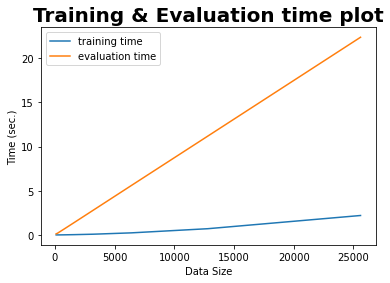

In [11]:
plt.plot(train_sizes, train_times)
plt.plot(train_sizes, eval_times)
plt.legend(["training time", "evaluation time"])
plt.xlabel("Data Size")
plt.ylabel("Time (sec.)")
plt.title('Training & Evaluation time plot',fontweight ="bold", fontsize=20)

Answer to part 5: 

<span style="font-family:Verdana; color: green;"> In the above cell we have plotted the evaluation and training times.</span>

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. 
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question 
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size. 
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues. 
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.

<span style="font-family:Verdana; color: green;"> In the cell below, we have plotted two figures. The figure on the left shows two plots (a) train sizes vs. accuracies (as calculated in the previous problem) (blue plot)and (b) train sizes vs predicted accuracy (orange plot) (predicted by a linear regressor). The figure on the right shows a linear plot shows train sizes vs predicted accuracy including the predict sizes. We observe two problems with this linear model: (1) Linear regression model show acuracies more than 1.0 (accuracy can never be more than 1.0) and (2) Expectedly the linear model cannot model the non-linear relationship between the accuracies and data size.</span>

R-Squared = 0.4177006634161019


(0.0, 7.0)

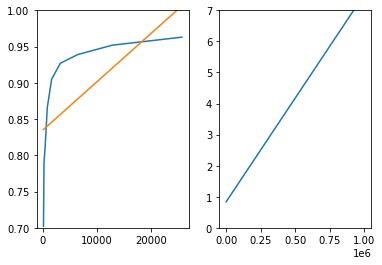

In [19]:
fig, ax = plt.subplots(1, 2)

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
predict_sizes = [25600, 60000, 120000, 1000000]
    
X = np.array(train_sizes).reshape(-1, 1)
y = np.array(accuracies).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print("R-Squared = " + str(reg.score(X, y)))
ax[0].plot(X, y)

X_ = np.array(train_sizes).reshape(-1, 1)
pred = reg.predict(X_)
y_ = np.array(pred).reshape(-1, 1)
ax[0].plot(X_, y_)
ax[0].set_ylim([0.7,1.0])


X1_ = np.array(train_sizes+predict_sizes).reshape(-1, 1)
pred = reg.predict(X1_)
y1_ = np.array(pred).reshape(-1, 1)
ax[1].plot(X1_, y1_)
ax[1].set_ylim([0,7])

<span style="font-family:Verdana; color: green;"> In the cell below we have plotted a sample logit function defined above. We will try to model the relationship between train sizes vs. predicted accuracy using the logit function. We will transform the data sizes such the logit maps to the accuracy data we generated in our problem. </span>

<ipython-input-12-bbcfa67e77c6>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


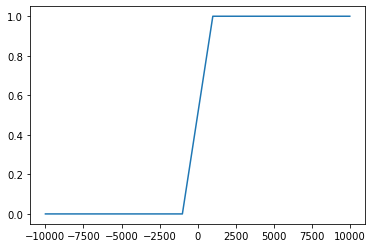

In [12]:
def logit(x):
    return 1/(1+np.exp(-x))

szs = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600])
acc = np.array([0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.963])

       
x = np.array([-10000, -9000, -8000, -7000, -6000, -5000, -4000, -3000, -2000, -1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
y = logit(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)

<span style="font-family:Verdana; color: green;"> In order to map the data sizes to accuracy through the logit  we will set up the equation as follows: $$a = \frac{1}{(1 + e^{-k*s})}$$ Where, the variable $a$ is the accuracy and $s$ is the data size for some arbitrary constant $k$. As the maximum value of the accuracy is 0.963 when the size is at 25600 and similarly the minimum value of the accuracy is 0.702 when the data size is at 100. We have the following equations: $$0.963 = \frac{1}{(1 + e^{-k*25600})}$$ $$0.702 = \frac{1}{(1 + e^{-k*100})}$$. Solving for k in both the equations we have k in the range $(0.000127, 0.008568)$. By picking a value in this range 0.00234785 we can use logit to model the mapping.</span>

R-Squared = 0.4177006634161019
Calcualted R-Squared = 0.9440548938222604


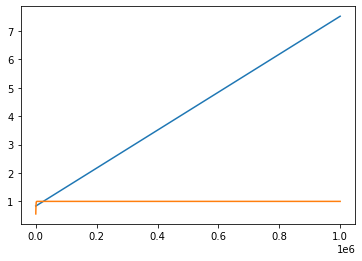

In [44]:
def logit(x):
    return 1/(1+np.exp(-x))

def logistic(x):
    return np.log(np.array(x)/(1-np.array(x)))

def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = np.mean(ys_orig)
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

def Q4():
    ### STUDENT START ###
    train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
    predict_sizes = [25600, 60000, 120000, 1000000]
    
    X = np.array(train_sizes).reshape(-1, 1)
    y = np.array(accuracies).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    print("R-Squared = " + str(reg.score(X, y)))
    
    
    k = 0.00234785
    y_ = logit(szs*k)
    
    corr_matrix = np.corrcoef(accuracies, y_)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    print("Calcualted R-Squared = " + str(R_sq))
    
    X1_ = np.array(train_sizes+predict_sizes).reshape(-1, 1)
    linear_pred = reg.predict(X1_)
    logit_pred = logit(X1_*k)

    plt.plot(X1_, linear_pred)
    plt.plot(X1_, logit_pred)
    ### STUDENT END ###

Q4()

In the plot above the following are some problems:
1. 

Answer to part 5:  

### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix. 
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).
1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

<span style="font-family:Verdana; color: green;"> In the below cell, we have used a KNN model with (K=1) as a model and trained the model with mini_train set. we predicted the dev set and printed the confusion matrix of the model. The confusion matrix shows show a 10x10 matrix. The diagonal elements represents the # of matches. For example the element (3, 3) tells that the model matches the label '3' 84 times correctly. And the element (3, 5) with value 6 means that the model confuses the label '3' with '5' 6 times.</span>

In [47]:
def Q5():
    ### STUDENT START ###
    # Instantiate a KNN model for K=1
    model = KNeighborsClassifier(n_neighbors=1)
    
    # fit the model for the mini train set
    model.fit(mini_train_data, mini_train_labels)
    
    # predict the values for dev set
    pred = model.predict(dev_data)
    
    # print the confusion matrix
    print(confusion_matrix(dev_labels, pred))
    ### STUDENT END ###

Q5()


[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


###### Answer to part 3: 

<span style="font-family:Verdana; color: green;"> From the confusion matrix, the model is most confused with label "8". The model confused "8" with "1" 5 times. Followed by labels "2" and "9". Label "8" was confused with "2" and "9" 4 times.<br> The code below prints each confused label and its corresponding image for the most confused label '8'. <span>

In [48]:
# We instantiated a KNN model with K = 1
# we fit the mini train set and predicted with the 
# dev set
model = KNeighborsClassifier(n_neighbors=1)
model.fit(mini_train_data, mini_train_labels)
pred = model.predict(dev_data)

# From the confusion matrix above we know label "8" 
# is misclassifed the most and it was misclassified 22 times
mis_classified_label = '8'

# we create a 22 subplots to display the misclassified image
fig, ax = plt.subplots(1, 22, sharey=True)

# this variable keeps the count of misclasification of "8"
count = 0
mis_labels = []

# we iterate through the dev set
for i in range(len(dev_data)):
    
    # we skip if the label is not misclassified
    if dev_labels[i] != mis_classified_label:
        continue
    
    # if the misclassification is equal to 22 then we 
    # are done
    if count >= 22:
        break
        
    # if label is misclassified
    if pred[i] != dev_labels[i]:
        # we add the image to the subplot
        img = dev_data[i].reshape(28, 28)
        ax[count].imshow(img, cmap='gray')
        
        # we add it to the list and add 1 to the count
        mis_labels.append(pred[i])
        count += 1
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);  

#finally we print the labels
print(mis_labels)

['1', '1', '3', '5', '5', '1', '9', '3', '9', '2', '2', '3', '7', '1', '9', '5', '1', '9', '2', '0', '2', '4']


As you see in the output, The first image was iterpreted as "1", the second second imgae is iterpreted to be "1" etc.